In [1]:
import pandas as pd
import numpy as np
import fastai
from sklearn.model_selection import StratifiedKFold
import torchvision.models as torch_models
import dill
from fastai.vision.all import *
import cloudpickle


from efficientnet_pytorch import EfficientNet

In [2]:
fastai.__version__

'2.3.0'

In [3]:
kaggle_path = '../input/'
N_SPLITS = 5

In [4]:
train = pd.read_csv(kaggle_path+'train.csv').sample(frac=1, random_state = 2021).reset_index(drop = True)

train['image'] = kaggle_path + 'train_images_512/' + train.chain.astype('str') + '/' + train.image
train['h_c'] = train['hotel_id'].astype('str')+' c'+train['chain'].astype('str')
#train = train[['image','hotel_id']]

In [5]:
train['chain_bucket']=train['chain'].map({0:1,
                                           6:2,
                                           5:3,
                                           90:4,
                                           3:4,
                                           89:4,
                                           87:5,
                                           4:5,
                                           2:5,
                                           88:5,
                                           9:6,
                                           82:6,
                                           78:6}).fillna(0)

In [6]:

skf = StratifiedKFold(n_splits=N_SPLITS, random_state=None, shuffle=False)

train.kfold = -1

for f, (t,v) in enumerate(skf.split(X = train, y = train.hotel_id.values)):
    train.loc[v, 'kfold'] = f

train.groupby('kfold')['hotel_id'].count()

/opt/conda/envs/ml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


kfold
0.0    19512
1.0    19511
2.0    19511
3.0    19511
4.0    19511
Name: hotel_id, dtype: int64

In [7]:
#train=train[train.chain_bucket==6]
train['is_demo_valid'] = False

#train.loc[train['kfold'] == 0, 'is_demo_valid'] = True

train.to_csv('train_folds.csv', index=False)

test=train[train.is_demo_valid == True]
#train=train[train.is_demo_valid == False]

In [8]:
train[(train.is_demo_valid)]#&(train.hotel_id==2252)(train.chain_bucket==4)&

,image,chain,hotel_id,timestamp,h_c,chain_bucket,kfold,is_demo_valid


<AxesSubplot:>

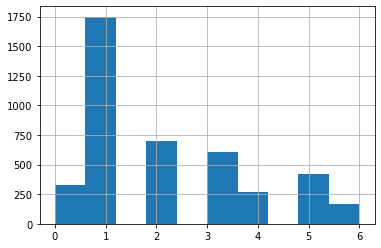

In [9]:
train[train.chain<10][['chain_bucket','hotel_id']].drop_duplicates().chain_bucket.hist()

In [10]:
#train[['chain','hotel_id']].drop_duplicates().groupby('chain').size().sort_values().tail(60)

In [11]:
dls = ImageDataLoaders.from_df(df = train[['image', 'hotel_id', 'is_demo_valid']], path = '.',folder = kaggle_path, valid_col = 'is_demo_valid',
                                item_tfms=Resize(448, method='pad', pad_mode='reflection')#448(224,224)
                               ,batch_tfms=aug_transforms(size=224)
                               ,bs=32) #48#[train.chain_bucket==1][train.chain_bucket==4], label_delim=' '[train.chain_bucket==4]

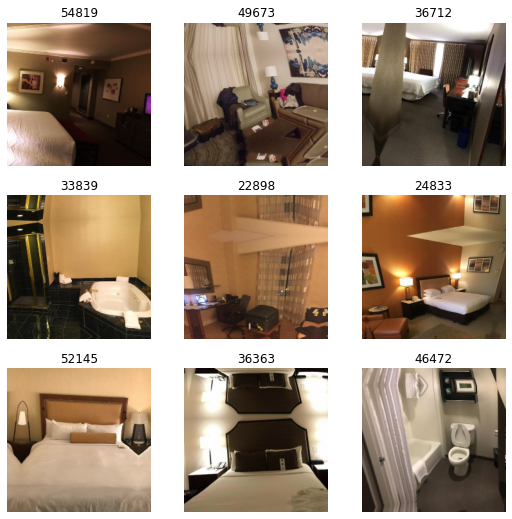

In [12]:
dls.show_batch() 

In [13]:

def myloss(pred,target):
    print(pred.shape,pred[0])
    print(target.shape,target[0])
    
def hotelacc(inp,targ):
    #print(inp.shape, inp[:,:-3].shape)
    inp = inp[:,:-88].topk(k=1, dim=-1)[1]
    targ = targ[:,:-88].topk(k=1, dim=-1)[1]
    return (inp == targ).sum(dim=-1).float().mean()

In [14]:
#https://www.kaggle.com/zzy990106/b0-bert-cv0-9

class ArcMarginProduct_subcenter(nn.Module):
    def __init__(self, in_features, out_features, k=1):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features*k, in_features))
        self.reset_parameters()
        self.k = k
        self.out_features = out_features
        
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        
    def forward(self, features):
        
        cosine_all = F.linear(F.normalize(features), F.normalize(self.weight))
        cosine_all = cosine_all.view(-1, self.out_features, self.k)
        cosine = torch.mean(cosine_all, dim=2)# cosine, _ =torch.max()
        #cosine,_ = torch.max(cosine_all, dim=2)# cosine, _ =torch.max()
        
        return cosine 
    
class CEMFlat(CrossEntropyLossFlat):
    
    #y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, axis=-1, **kwargs):
        self.reduce = kwargs.pop('reduction') if 'reduction' in kwargs else 'mean'
        super().__init__(*args, reduction='none', axis=axis, **kwargs)
    
    def __call__(self, inp, targ, **kwargs):
        
        index = torch.where(targ != -1)[0]
        m_hot = torch.zeros(index.size()[0], inp.shape[1], device=inp.device)
        m_hot.scatter_(1, targ[index,None], 0.3)
        
        #v=inp[0].cpu().detach().numpy()
        x=inp
        x.acos_()
        
        x[index] += m_hot
        x.cos_().mul_(4)#16
        #print('OOO',(inp[0].cpu().detach().numpy()-v).sum())
        
        ce_loss = super().__call__(x, targ, **kwargs)
        #pt = torch.exp(-ce_loss)
        #fl_loss = (1-pt)**self.gamma * ce_loss
        return ce_loss.mean() if self.reduce == 'mean' else ce_loss.sum() if self.reduce == 'sum' else ce_loss

class CEMFlat1(CrossEntropyLossFlat):
    
    #y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, axis=-1, **kwargs):
        self.reduce = kwargs.pop('reduction') if 'reduction' in kwargs else 'mean'
        super().__init__(*args, reduction='none', axis=axis, **kwargs)
    
    def __call__(self, inp, targ, **kwargs):
        
        index = torch.where(targ != -1)[0]
        m_hot = torch.zeros(index.size()[0], inp.shape[1], device=inp.device)
        m_hot.scatter_(1, targ[index,None], 0.3)
        
        #inp.acos_()
        inp[index] -= m_hot
        #inp.cos_().mul_(16)
        
        ce_loss = super().__call__(inp, targ, **kwargs)
        #pt = torch.exp(-ce_loss)
        #fl_loss = (1-pt)**self.gamma * ce_loss
        return ce_loss.mean() if self.reduce == 'mean' else ce_loss.sum() if self.reduce == 'sum' else ce_loss

In [15]:
class HotelHead(nn.Module):
    
    def __init__(self, f_in, f_out): #, f_out_aux):
        super(HotelHead, self).__init__()
        
        self.bn1 = nn.BatchNorm1d(f_in, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.do1 = nn.Dropout(0.25)
        self.lin1 = nn.Linear(f_in, f_in, bias = False)
        self.rl = nn.ReLU(inplace=True)
        
        self.bn2 = nn.BatchNorm1d(f_in, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.do2 = nn.Dropout(0.5)
        self.lin2 = nn.Linear(f_in, f_out, bias = False)
        
        #self.bn2a = nn.BatchNorm1d(f_in, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        #self.do2a = nn.Dropout(0.5)
        #self.lin2a = nn.Linear(f_in, f_out_aux, bias = False)
        
        
    def forward(self, x):
        
        x = self.bn1(x)
        x = self.do1(x)
        x = self.lin1(x)
        x1 = self.rl(x)
        
        x = self.bn2(x1)
        x = self.do2(x)
        x = self.lin2(x)
        
        #x_aux = self.bn2a(x1)
        #x_aux = self.do2a(x_aux)
        #x_aux = self.lin2a(x_aux)
        
        return x #{'outs': x, 'outs_aux': x_aux}

In [16]:
#eff_model = EfficientNet.from_pretrained('efficientnet-b1')
#num_ftrs = eff_model._fc.in_features
#eff_model._avg_pooling = fastai.layers.AdaptiveConcatPool2d()
#eff_model._fc= nn.Linear(num_ftrs, dls.c) #HotelHead(num_ftrs, dls.c)

#learn = Learner(dls, eff_model, metrics=[accuracy, top_k_accuracy]).to_fp16()#, opt_func=QHAdam, loss_func=LabelSmoothingCrossEntropyFlat(eps=0.07)).to_fp16()
#learn.clip_grad=1.0

In [17]:
#, loss_func=LabelSmoothingCrossEntropyFlat(eps=0.07)
learn = cnn_learner(dls, densenet161, metrics=[accuracy, top_k_accuracy], opt_func=QHAdam, loss_func = FocalLossFlat(gamma = 2)).to_fp16() #, loss_func= cep_margin), loss_func=CEMFlat()


In [18]:
#learn.model
#learn.lr_find()

In [19]:
%time
#learn.loss_func = FocalLossFlat(gamma = 2)
#learn.freeze()
#learn.fit_one_cycle(1,0.005)
#learn.loss_func = LabelSmoothingCrossEntropyFlat(eps=0.07)
#learn.unfreeze()
#learn.fit_one_cycle(10,slice(0.005/200,0.005/2),pct_start=0.3, div=5.0)

learn.fine_tune(10, 0.005, freeze_epochs=1) #, cbs=MixUp()) 

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,7.464571,None,None,None,19:23


/opt/conda/envs/ml/lib/python3.6/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.228044,None,None,None,24:59
1,5.145716,None,None,None,25:19
2,4.399781,None,None,None,25:14
3,3.637102,None,None,None,24:59
4,2.922656,None,None,None,24:58
5,2.247908,None,None,None,25:03
6,1.572742,None,None,None,25:02
7,1.063070,None,None,None,25:09
8,0.677767,None,None,None,25:07
9,0.552602,None,None,None,25:09


In [20]:
learn.export(f'export_dn161_Fa_FL_bs32.pkl', pickle_module=dill)

In [21]:
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.741653	None	None	None	19:23
/opt/conda/envs/ml/lib/python3.6/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	6.612468	None	None	None	25:02
1	5.807178	None	None	None	25:06
2	5.096242	None	None	None	25:16
3	4.369295	None	None	None	25:30
4	3.875755	None	None	None	26:02
5	3.244581	None	None	None	25:18
6	2.763785	None	None	None	25:35
7	2.250430	None	None	None	25:37
8	1.957588	None	None	None	25:25
9	1.844540	None	None	None	25:23
#dn161 bs32 c6 focal2

#dn161 bs32 c6 labs0.07
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	6.609099	5.484115	0.119365	0.253333	01:27

epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	4.487258	4.229106	0.283175	0.441905	01:46
1	3.770890	3.670585	0.380317	0.553016	01:45


SyntaxError: invalid syntax (<ipython-input-21-e563df5c46ea>, line 1)

In [ ]:
#res50 labsmo clip

#res50 labsmo
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.256621	7.902405	0.038233	0.086870	06:21
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.404080	7.039046	0.117927	0.198698	07:36
1	6.397611	5.944442	0.190242	0.314012	07:46
2	5.484532	5.133696	0.276599	0.435937	07:30
3	4.674928	4.583207	0.359881	0.523934	07:28
4	4.008585	4.202835	0.420152	0.588766	07:28
5	3.318379	3.917936	0.473093	0.636993	07:29
6	2.740614	3.698725	0.514914	0.674969	07:28
7	2.308738	3.560153	0.537823	0.696341	07:29
8	2.004384	3.493863	0.552224	0.705976	07:28
9	1.880667	3.487164	0.554121	0.707155	07:29

#res50 clip ce
CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 10.5 µs
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.149858	7.763881	0.041615	0.089227	08:34
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.177454	6.796816	0.120029	0.199775	10:43
1	6.035224	5.553545	0.189114	0.321033	10:43
2	4.972515	4.629770	0.273729	0.434092	10:43
3	4.072265	3.971362	0.352091	0.517169	10:42
4	3.197044	3.508144	0.414463	0.581847	10:43
5	2.469465	3.169313	0.466021	0.631355	10:43
6	1.783229	2.947474	0.502511	0.665539	10:43
7	1.148532	2.819263	0.535465	0.689268	10:43
8	0.788978	2.746905	0.548278	0.702235	10:48
9	0.658753	2.750164	0.550379	0.702440	10:44


# res18c6 clip sl0,07
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.190894	5.891718	0.048254	0.138413	00:26
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	5.548172	5.237214	0.121905	0.249524	00:27
1	4.867079	4.663380	0.204444	0.355556	00:27
2	4.219921	4.154126	0.280000	0.460317	00:26
3	3.516733	3.852093	0.330794	0.499683	00:26
4	2.848212	3.604245	0.378413	0.569524	00:26
5	2.319115	3.404141	0.423492	0.608254	00:26
6	1.895884	3.275020	0.453333	0.639365	00:26
7	1.613365	3.200686	0.466667	0.654603	00:26
8	1.471635	3.181858	0.468571	0.656508	00:26
9	1.396962	3.177948	0.469841	0.655238	00:26

# res18c6 clip ce
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.228976	5.823389	0.051429	0.142222	00:26
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	5.319182	5.048251	0.144762	0.265397	00:28
1	4.599944	4.420105	0.216508	0.355556	00:27
2	3.878725	3.914351	0.271111	0.432381	00:26
3	3.085130	3.529186	0.321270	0.514286	00:27
4	2.312331	3.146353	0.386667	0.573968	00:27
5	1.588170	2.919218	0.434286	0.619683	00:27
6	1.063480	2.797227	0.464127	0.633016	00:27
7	0.774587	2.707223	0.472381	0.653333	00:27
8	0.584814	2.672152	0.476190	0.660317	00:27
9	0.505343	2.663877	0.478095	0.662222	00:27


res18c6 labs 0.07
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.239416	5.856543	0.059683	0.146667	00:25
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	5.466718	5.212001	0.133333	0.252698	00:25
1	4.835261	4.619191	0.206984	0.377778	00:26
2	4.205906	4.212378	0.267936	0.450159	00:25
3	3.523609	3.880972	0.326349	0.529524	00:26
4	2.843379	3.599849	0.373968	0.581587	00:26
5	2.271882	3.413404	0.417143	0.608254	00:26
6	1.870606	3.288810	0.452698	0.635556	00:26
7	1.607707	3.217711	0.462222	0.649524	00:26
8	1.455466	3.185670	0.462857	0.657143	00:25
9	1.386609	3.189022	0.463492	0.652698	00:26

In [ ]:
#res18 all focal gamma5

#res18 all labsmo eps0.07
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.472342	8.160601	0.024549	0.058887	05:20
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.663422	7.449046	0.079182	0.148421	05:11
1	6.788261	6.407310	0.146833	0.252819	05:08
2	5.964534	5.685244	0.212126	0.351732	05:09
3	5.257882	5.144168	0.282800	0.435937	05:09
4	4.533796	4.760441	0.338612	0.504613	05:09
5	3.949515	4.497562	0.379766	0.543665	05:10
6	3.420941	4.298407	0.416718	0.582411	05:10
7	2.880312	4.161891	0.448442	0.603782	05:09
8	2.527267	4.119333	0.454951	0.614545	05:09
9	2.383475	4.110469	0.457155	0.615314	05:17
    
#101labsmoo eps.07
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.167388	7.766789	0.048227	0.101886	09:02
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.257146	6.917398	0.134123	0.219045	11:10
1	6.276642	5.862312	0.199313	0.332103	11:10
2	5.407816	5.077074	0.284030	0.443214	11:10
3	4.569158	4.511129	0.369209	0.541462	11:11
4	3.913746	4.135839	0.428557	0.598657	11:11
5	3.321203	3.824293	0.487290	0.651291	11:11
6	2.715018	3.600127	0.529623	0.689268	11:11
7	2.241652	3.452616	0.556222	0.711818	11:11
8	1.921785	3.381120	0.569854	0.723350	11:11
9	1.785978	3.368180	0.572724	0.725246	11:11
    
#res50 all padded resize HQAdam

epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.184557	7.738400	0.040539	0.087792	06:20
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.156171	6.764578	0.118337	0.201312	07:33
1	6.017654	5.547440	0.184348	0.315703	07:32
2	4.954804	4.669734	0.267579	0.426558	07:32
3	3.984981	3.975394	0.347940	0.518860	07:33
4	3.183610	3.529619	0.413182	0.579541	07:33
5	2.435921	3.219519	0.461767	0.627921	07:33
6	1.760477	2.960891	0.501435	0.664565	07:33
7	1.152619	2.846337	0.530750	0.684348	07:33
8	0.778958	2.771853	0.542845	0.698032	07:33
9	0.689957	2.764618	0.544793	0.700236	07:34


#res50 all no aug HQAdam

epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.099021	7.672452	0.050072	0.101630	05:14
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.024560	6.701533	0.128126	0.211870	06:29
1	5.970382	5.522499	0.193983	0.320418	06:29
2	4.949619	4.684256	0.270090	0.423995	06:51
3	3.968697	4.048282	0.344762	0.510865	06:42
4	3.105205	3.661313	0.395705	0.568163	06:41
5	2.294243	3.367522	0.444957	0.611572	06:33
6	1.541104	3.225096	0.480320	0.642118	06:29
7	0.893848	3.128287	0.504715	0.662208	06:29
8	0.559355	3.067192	0.516913	0.669690	06:29
9	0.424328	3.068796	0.518604	0.670869	06:29

#res18 all padrefl HQAdam
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.356600	8.033181	0.024856	0.061501	05:16
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.517679	7.262202	0.084205	0.152163	05:14
1	6.549900	6.040623	0.144731	0.258866	05:13
2	5.507288	5.211685	0.211972	0.355320	05:13
3	4.653226	4.585835	0.279367	0.438499	05:12
4	3.939388	4.137090	0.331591	0.498309	05:13
5	3.169961	3.836134	0.375461	0.545510	05:12
6	2.409171	3.625236	0.412208	0.577081	05:13
7	1.826044	3.477538	0.440652	0.603782	05:13
8	1.426002	3.438044	0.449262	0.612085	05:12
9	1.265840	3.428241	0.449672	0.613930	05:12


In [ ]:
import cloudpickle

In [ ]:
import cloudpickle
learn.export(f'export_res50_F0_LSMoo.pkl', pickle_module=cloudpickle)

In [ ]:
train #[train.is_demo_valid==False]0.008929	0.012500	

In [ ]:
prob, tar, pred = learn.get_preds(ds_idx=1,with_decoded=True)

#test_dl=learn.dls.test_dl(train[['image','hotel_id']].iloc[440:600])
#prob, tar =learn.get_preds(dl=test_dl)#ds_idx=1,with_decoded=True)
prob, tar

In [ ]:
#learn.dls[1].after_batch #.dataset[0]

In [ ]:
prob[0].topk(5) ,tar[0], dls.vocab[342], prob.shape,prob[0][342]

In [ ]:
test_dl=learn.dls.test_dl(test, item_tfms=Resize(448), batch_tfms=aug_transforms(size=224))
prob, tar =learn.get_preds(dl=test_dl)#ds_idx=1,with_decoded=True)
prob, tar

In [ ]:
#test_dl.after_batch

In [ ]:
prob[0].topk(10) , dls.vocab[342], prob.shape,prob[0][342]

In [ ]:
test_dl.dataset[0]#.show()

In [ ]:
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	6.725233	6.691653	0.025446	0.054464	00:43
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	6.666232	6.648721	0.061607	0.118750	00:49
    
# chain4 res18
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.417761	6.129266	0.055804	0.137946	00:32
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	5.712602	5.375559	0.122321	0.237054	00:32
1	5.034863	4.860949	0.177232	0.305804	00:34
2	4.528499	4.417047	0.211607	0.365625	00:32
3	3.875956	4.055223	0.249107	0.416518	00:34
4	3.239520	3.767382	0.287946	0.466071	00:34
5	2.583438	3.546301	0.326339	0.500893	00:32
6	1.948013	3.359771	0.359821	0.548214	00:34
7	1.464740	3.260402	0.383036	0.563839	00:33
8	1.183184	3.219965	0.389732	0.568304	00:35
9	1.036684	3.208099	0.388839	0.567857	00:33

    
# chain4 res18 with arc(k5 mean)
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	6.541726	6.526719	0.700000	0.992857	00:42
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	6.516261	6.510182	0.658482	0.985268	00:49
1	6.501825	6.492661	0.595536	0.983482	00:49
2	6.486174	6.478865	0.519196	0.966518	00:49
3	6.468045	6.462359	0.508482	0.964732	00:49
4	6.450371	6.449969	0.526339	0.970089	00:49
5	6.434631	6.437826	0.562500	0.978125	00:49
6	6.419397	6.428612	0.575446	0.977679	00:49
7	6.410842	6.423662	0.598661	0.972321	00:49
8	6.401272	6.421358	0.606250	0.972321	00:49
9	6.398186	6.420961	0.602679	0.973214	00:49

# chain4 res18 with arc(k1)
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	6.524926	6.491221	0.189286	0.529018	00:41
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	6.468594	6.452563	0.254018	0.577679	00:48
1	6.432246	6.414721	0.264286	0.583036	00:48
2	6.399032	6.379938	0.274554	0.568750	00:48
3	6.360778	6.347869	0.288393	0.592411	00:48
4	6.324476	6.321461	0.324107	0.616964	00:48
5	6.286507	6.296262	0.345982	0.645536	00:48
6	6.258912	6.276107	0.374107	0.659821	00:48
7	6.232644	6.264833	0.398214	0.683482	00:48
8	6.211616	6.259295	0.410714	0.688393	00:49
9	6.205580	6.258278	0.407143	0.687054	00:49

In [ ]:
learn.export(f'export.pkl')

In [ ]:
#res50 bs64 arcm, cem +=m
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.837965	8.831619	0.308682	0.775369	06:25
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.823522	8.819674	0.291052	0.770603	07:20
1	8.812909	8.806095	0.211665	0.692394	07:23
2	8.799928	8.790311	0.182093	0.600041	07:22
3	8.786133	8.772222	0.179069	0.593276	07:19
4	8.772529	8.756088	0.195521	0.591328	07:21
5	8.759800	8.741478	0.205258	0.600451	07:21
6	8.749186	8.730001	0.216533	0.615262	07:22
7	8.736682	8.721563	0.230422	0.637198	07:22
8	8.731894	8.717832	0.236419	0.638428	07:21
9	8.730051	8.717113	0.238161	0.639196	07:41
    
#res50 bs64
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.317183	7.921312	0.040590	0.085588	08:20
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.528651	7.170936	0.105371	0.175482	10:13
1	7.204895	6.653473	0.142886	0.232677	10:20
2	6.941136	6.286196	0.167589	0.267374	10:05
3	6.528665	5.755139	0.214996	0.324160	10:03
4	6.070248	5.317997	0.256970	0.379561	10:02
5	5.609989	4.938997	0.302327	0.429274	10:03
6	5.157987	4.606316	0.342968	0.484112	10:05
7	4.599042	4.396810	0.379920	0.516298	10:04
8	4.102228	4.315802	0.398011	0.533210	10:18
9	3.682967	4.314715	0.398268	0.534697	10:06
    

#res34
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	8.415315	8.058720	0.032288	0.069906	04:42
epoch	train_loss	valid_loss	accuracy	top_k_accuracy	time
0	7.686148	7.397623	0.091636	0.154110	05:34
1	7.316401	6.885247	0.119721	0.199826	05:33
2	7.127475	6.494644	0.142118	0.239442	05:34
3	6.733458	6.087039	0.181478	0.288592	05:30
4	6.380781	5.688229	0.223555	0.335332	05:29
5	5.979268	5.359049	0.261685	0.380791	05:30
6	5.593188	5.036254	0.295613	0.425123	05:30
7	5.061710	4.871400	0.325543	0.452132	05:30
8	4.684802	4.782250	0.341021	0.465406	05:30
9	4.308330	4.780612	0.341636	0.466277	05:30


#res18

epoch	train_loss	valid_loss	accuracy	time
0	8.451213	8.127793	0.026804	04:26
epoch	train_loss	valid_loss	accuracy	time
0	7.786336	7.513499	0.076825	04:27
1	7.461221	6.939682	0.115314	04:24
2	7.167302	6.559566	0.142938	04:25
3	6.890818	6.188414	0.171382	04:26
4	6.566433	5.831934	0.210076	04:21
5	6.208480	5.529561	0.243645	04:21
6	5.687847	5.275159	0.276394	04:21
7	5.288332	5.110462	0.298944	04:22
8	4.922027	5.043629	0.313089	04:22
9	4.557464	5.023990	0.314678	04:22

In [ ]:
interp = Interpretation.from_learner(learn)

interp.plot_top_losses(9, figsize=(15,10))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix(figsize=(7,7))

In [ ]:
## chain 1 resnext101
epoch	train_loss	valid_loss	accuracy	time
0	7.180262	6.626441	0.070600	06:16
epoch	train_loss	valid_loss	accuracy	time
0	6.094551	5.974283	0.141940	08:45
1	5.705760	5.458116	0.187361	08:44
2	5.353799	5.179721	0.218465	08:45
3	5.045684	4.787757	0.257961	08:45
4	4.388067	4.463748	0.303629	08:45
5	3.814906	4.214329	0.338929	08:45
6	3.151538	3.996331	0.366329	08:49
7	2.589321	3.854836	0.391755	08:45
8	2.137407	3.786668	0.409775	08:44
9	1.722539	3.783929	0.407307	08:45

In [ ]:
## chain
epoch	train_loss	valid_loss	accuracy	time
0	2.900834	2.685299	0.316796	25:11
epoch	train_loss	valid_loss	accuracy	time
0	2.420417	2.304435	0.414997	25:27
1	2.007528	1.878275	0.515709	25:28
2	1.694720	1.675625	0.568859	25:31